In [1]:
%matplotlib nbagg
import gym
import numpy as np
import torch
import torch.nn
import torch.optim
import torch.nn.functional
import torch.distributions
import matplotlib.pyplot as plt

In [2]:
class Policy(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env

    def __new__(cls, env, *args, **kwargs):
        if isinstance(env.action_space, gym.spaces.Box):
            return ContinuousActionPolicy(env, *args, **kwargs)
        elif isinstance(env.action_space, gym.spaces.Discrete):
            return DiscreteActionPolicy(env, *args, **kwargs)


class ContinuousActionPolicy(torch.nn.Module):
    def __init__(self, env):
        assert isinstance(env.action_space, gym.spaces.Box)
        assert isinstance(env.observation_space, gym.spaces.Box)
        super().__init__()
        self.affine1 = torch.nn.Linear(env.observation_space.shape[0], 64)
        self.affine_mean = torch.nn.Linear(64, env.action_space.shape[0])
        self.affine_std = torch.nn.Linear(64, env.action_space.shape[0])
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        hidden1 = self.affine1(state)
        activation1 = torch.nn.functional.relu(hidden1)

        hidden_mean = self.affine_mean(activation1)
        mean = torch.nn.functional.softmax(hidden_mean, dim=1)
        hidden_std = self.affine_std(activation1)
        std = torch.nn.functional.softmax(hidden_std, dim=1)

        action_distribution = torch.distributions.MultivariateNormal(mean, torch.diag(torch.ones_like(mean).view(-1)))
        action = action_distribution.sample()
        policy.saved_log_probs.append(action_distribution.log_prob(action))
        return action


class DiscreteActionPolicy(torch.nn.Module):
    def __init__(self, env):
        assert isinstance(env.action_space, gym.spaces.Discrete)
        assert isinstance(env.observation_space, gym.spaces.Box)
        super().__init__()
        self.affine1 = torch.nn.Linear(env.observation_space.shape[0], 64)
        self.affine2 = torch.nn.Linear(64, env.action_space.n)
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        hidden1 = self.affine1(state)
        activation1 = torch.nn.functional.relu(hidden1)
        hidden2 = self.affine2(activation1)
        action_probabilities = torch.nn.functional.softmax(hidden2, dim=1)
        action_distribution = torch.distributions.Categorical(action_probabilities)
        action = action_distribution.sample()
        policy.saved_log_probs.append(action_distribution.log_prob(action))
        return int(action)

In [3]:
class TrainingMonitor:
    def __init__(self, env, agent, optimizer):
        self.env = env
        self.agent = agent
        self.optimizer = optimizer
        self.rewards = env.stats_recorder.episode_rewards
        self.mean_rewards = []
        self.losses = []
        self.figure, self.axes = plt.subplots(2, 1)

        self.axes[0].set_title('Training Monitor')
        self.axes[0].set_ylabel('Reward')
        self.axes[0].plot([], [], 'go', label='Episode Reward')
        self.axes[0].plot([], [], 'g', label='Mean Reward (50)')

        self.axes[1].set_ylabel('Training Loss')
        self.axes[1].set_xlabel('Episode ')
        self.axes[1].plot([], [], label='Training Loss')

    def plot(self):
        self.episodes = range(len(self.rewards))
        self.mean_rewards.append(sum(self.rewards[-50:])/50)
        self.losses.append(float(self.optimizer.loss))

        self.axes[0].lines[0].set_xdata(self.episodes)
        self.axes[0].lines[0].set_ydata(self.rewards)
        self.axes[0].lines[1].set_xdata(self.episodes)
        self.axes[0].lines[1].set_ydata(self.mean_rewards)
        self.axes[0].relim()
        self.axes[0].autoscale_view()

        self.axes[1].lines[0].set_xdata(self.episodes)
        self.axes[1].lines[0].set_ydata(self.losses)
        self.axes[1].relim()
        self.axes[1].autoscale_view()

        self.figure.canvas.draw()
        plt.pause(0.001)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


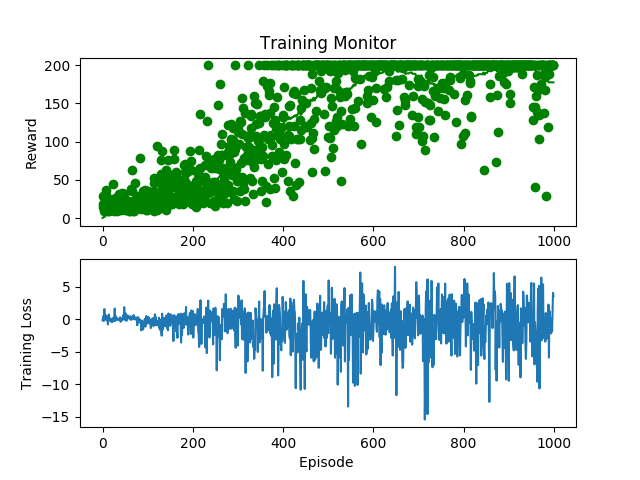

In [4]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, directory='monitor', force=True, video_callable=False)
policy = Policy(env)
optimizer = torch.optim.Adam(policy.parameters())
monitor = TrainingMonitor(env, policy, optimizer)
eps = np.finfo(np.float32).eps.item()

for episode_num in range(1_000):
    state, done = env.reset(), False
    while not done:
        action = policy(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)

    policy_loss, rewards, R = [], [], 0
    for r in policy.rewards[::-1]:
        R = r + 0.99 * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)
    optimizer.zero_grad()
    optimizer.loss = torch.cat(policy_loss).sum()
    optimizer.loss.backward()
    optimizer.step()
    monitor.plot()

    del policy.rewards[:]
    del policy.saved_log_probs[:]